In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import json
from collections import defaultdict, Counter, namedtuple
from itertools import combinations
from tabulate import tabulate
import sys
import json
PROJECT_PATH = '/Users/guydavidson/projects/game-generation-modeling'
sys.path.append(PROJECT_PATH)

In [2]:
from schema.validate_schema import load_and_validate_game_schema
SCHEMA_FILE = '../schema/game_schema_with_refs.json'
GAME_SCHEMAS_FILE = '../schema/interactive_beta.json'

In [3]:
def schema_to_df_row(game_schema):
    row = defaultdict(list)
    row.update(game_schema['metadata'])

    row['game_name'] = row['prolific_id']
    row['is_throwing'] = 0
    row['is_building'] = 0
    row['is_organizing'] = 0
    objects_with_predicates = []

    if 'throwing' in game_schema:
        throwing_game = game_schema['throwing']
        row['is_throwing'] = 1
        row['throwing_objects'] = throwing_game['what']
        row['throwing_goal'] = throwing_game['goal']
        
        for key in ('to', 'from', 'on'):
            if key in throwing_game:
                value = throwing_game[key]
                row[f'throwing_{key}'] = value
                objects_with_predicates.extend(value)

    if 'building' in game_schema:
        building_game = game_schema['building']
        row['is_building'] = 1
        row['building_objects'] = building_game['objects']
        row['building_goal'] = building_game['goal']
        row['building_structure'] = building_game['structure'] if 'structure' in building_game else None
        row['building_order'] = building_game['order'] if 'order' in building_game else None

        if 'on' in building_game:
            objects_with_predicates.append(building_game['on'])

    if 'organizing' in game_schema:
        row['is_organizing'] = 1
        row['organizing'] = game_schema['organizing']
        for org_game in game_schema['organizing']:
            row['organizing_objects'].extend(org_game['what'])
            if 'from' in org_game:
                objects_with_predicates.append(org_game['from'])
            objects_with_predicates.extend(org_game['to'])

    row['objects_with_predicates'] = objects_with_predicates

    return row


In [4]:
stats_df = pd.read_csv('../data/dsl_statistics_interactive.csv', index_col='Index')

game_schemas = load_and_validate_game_schema(GAME_SCHEMAS_FILE, SCHEMA_FILE)
game_schema_rows = [schema_to_df_row(game_schema) for game_schema in game_schemas]
schema_df = pd.DataFrame(game_schema_rows)
# manual_df = pd.read_csv('../data/manual_dsl_statistics.csv')
stats_df = stats_df.merge(schema_df, on='game_name')
stats_df.shape

44


(44, 33)

In [5]:
stats_df.loc[stats_df.terminal_exists.isna(), 'terminal_exists'] = False

room = np.zeros((len(stats_df),), dtype=np.int)
room[['medium' in d for d in stats_df.domain_name]] = 1
room[['many' in d for d in stats_df.domain_name]] = 2

room_name = ['Few'] * len(stats_df)
stats_df = stats_df.assign(room=room, room_name=room_name)

stats_df.loc[['medium' in d for d in stats_df.domain_name], 'room_name'] = 'Medium'
stats_df.loc[['many' in d for d in stats_df.domain_name], 'room_name'] = 'Many'

stats_df.src_file = stats_df.src_file.apply(lambda s: s.replace('problems-', '').replace('.pddl', ''))
room[['interactive' in s for s in stats_df.src_file]] = 3
stats_df = stats_df.assign(src=room)

def list_from_text(list_text):
    if isinstance(list_text, str):
        return np.fromstring(list_text[1:-1], sep=',', dtype=np.int)
    
    return []

stats_df = stats_df.assign(length_of_then=stats_df.length_of_then.apply(list_from_text))
stats_df = stats_df.assign(setup_objects_quantified=stats_df.setup_objects_quantified.apply(list_from_text))
stats_df = stats_df.assign(preference_objects_quantified=stats_df.preference_objects_quantified.apply(list_from_text))


def average_list_series(df, name):
    avg = np.empty_like(df[name])
    avg[:] = np.NaN
    for i, entry in df[name].iteritems():
        if len(entry) > 0:
            avg[i] = np.mean(entry)

    return df.assign(**{f'average_{name}': avg})

stats_df = average_list_series(stats_df, 'length_of_then')
stats_df = average_list_series(stats_df, 'setup_objects_quantified')
stats_df = average_list_series(stats_df, 'preference_objects_quantified')

GAME_TYPES = ('throwing', 'building', 'organizing')
game_type_data = [[type_name for type_name in GAME_TYPES if row[f'is_{type_name}']]
    for i, row in stats_df.iterrows()]


stats_df = stats_df.assign(game_type=game_type_data)


def dict_from_str_with_key_filters(keys_to_filter):
    def inner(dict_str):
        d = json.loads(dict_str.replace("'",'"'))
        for key in keys_to_filter:
            if key in d:
                del d[key]

        return d

    return inner

OBJECT_TYPES_REFERENCED_KEYS_TO_FILTER = ('back', 'front', 'left', 'right', 'upright', 'upside_down')

stats_df = stats_df.assign(object_types_referenced=stats_df.object_types_referenced.apply(dict_from_str_with_key_filters(OBJECT_TYPES_REFERENCED_KEYS_TO_FILTER)))

stats_df = stats_df.assign(predicates_referenced=stats_df.predicates_referenced.apply(dict_from_str_with_key_filters([])))
    

In [6]:
stats_df.columns

Index(['src_file', 'game_name', 'domain_name', 'length_of_then',
       'num_preferences', 'setup_objects_quantified',
       'preference_objects_quantified', 'terminal_exists',
       'object_types_referenced', 'predicates_referenced', 'max_depth',
       'ast_nodes', 'setup_nodes', 'prolific_id', 'id', 'index', 'room',
       'notes', 'is_throwing', 'is_building', 'is_organizing',
       'throwing_objects', 'throwing_goal', 'throwing_to', 'throwing_on',
       'objects_with_predicates', 'throwing_from', 'building_objects',
       'building_goal', 'building_structure', 'building_order', 'organizing',
       'organizing_objects', 'room_name', 'src', 'average_length_of_then',
       'average_setup_objects_quantified',
       'average_preference_objects_quantified', 'game_type'],
      dtype='object')

In [7]:
DIFFICULTIES = ('Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard')
ROOM_NAMES = ('Few', 'Medium', 'Many')

REORDERED_COLUMNS = ['src', 'src_file', 'game_name', 'domain_name', 'room', 'room_name',
    'num_preferences', 'length_of_then', 'average_length_of_then',
    'setup_objects_quantified', 'average_setup_objects_quantified',
    'preference_objects_quantified', 'average_preference_objects_quantified',
    'terminal_exists', 'object_types_referenced', 'predicates_referenced', 
    'max_depth', 'ast_nodes', 'setup_nodes',
    'game_type', 'is_throwing', 'is_building', 'is_organizing', 'objects_with_predicates',
    'throwing_objects', 'throwing_goal', 'throwing_to', 'throwing_from', 'throwing_on',
    'building_objects', 'building_goal', 'building_structure', 'building_order', 
    'organizing', 'organizing_objects',
]
stats_df = stats_df.reindex(columns=REORDERED_COLUMNS)

In [8]:
stats_df.head()

,src,src_file,game_name,domain_name,room,room_name,num_preferences,length_of_then,average_length_of_then,setup_objects_quantified,...,throwing_goal,throwing_to,throwing_from,throwing_on,building_objects,building_goal,building_structure,building_order,organizing,organizing_objects
0,3,interactive-beta,6172feb1665491d1efbce164,medium-objects-room-v1,1,Medium,2,"[3, 2]",2.5,[2],...,[hit],[{'object': 'hexagonal_bin'}],NaN,"[{'object': 'large_triangular_ramp', 'predicat...",NaN,NaN,NaN,NaN,NaN,NaN
1,3,interactive-beta,5f77754ba932fb2c4ba181d8,many-objects-room-v1,2,Many,2,"[3, 3]",3,[],...,[in],"[{'object': 'top_drawer', 'predicates': [{'pre...","[{'object': 'door', 'predicates': [{'predicate...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,interactive-beta,614b603d4da88384282967a7,many-objects-room-v1,2,Many,1,[],NaN,[],...,NaN,NaN,NaN,NaN,[block],num_objects,tower,None,NaN,NaN
3,3,interactive-beta,5bc79f652885710001a0e82a,few-objects-room-v1,0,Few,1,[3],3,[],...,[in],[{'object': 'hexagonal_bin'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,interactive-beta,614dec67f6eb129c3a77defd,medium-objects-room-v1,1,Medium,2,"[3, 3]",3,"[1, 1]",...,[in],"[{'object': 'hexagonal_bin', 'predicates': [{'...","[{'object': 'desk', 'predicates': [{'predicate...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dataframe columns readme:
* `src/src_file`: which file the data came from (survey by specific room or interactive beta)
* `game_name`: room-\[row number in my spreadsheet\].
* `domain_name`: the room identifier as it's iun the games (domain is a PDDL thing)
* `room/room_name`: simplifications of the room designation from the game/domain names to ease working with the data.
* `num_preferences`: how many preferences I used to represent the game.
* `length_of_then`: length of all `then` operators in this game.
* `setup/preference_objects_quantified`: average number of objects quantified over in quantifiers (`exists`/`forall`) in the game representation, split by which section of the game it's in.
* `terminal_exists`: whether the game uses a `terminal` clause.
* `object_types_referenced`: how many times each object type was quantified in each game, combined between the setup and preferences. 
* `predicates_referenced`: how many times each predicate was referenced in each game (as above, combined between setup and preferences). 
* `max_depth`: what's the deepest the game's AST goes
* `ast_nodes`: how many total nodes of type AST (so not strings, lists, etc.) exist in the AST.
* `is_throwing/building/organizing`: does the schema representaiton of this game utilize this sort of block?
* `objects_with_predicates`: a list of all of the `objectWithPredicate` types used in the schema representation of this game
* `throwing_*/building_*/organizing_*`: individual fields from the schema representation for each type.

# Schema-based analyses
## How many games of each type exist



Text(0.5, 1.0, 'Count of games by type')

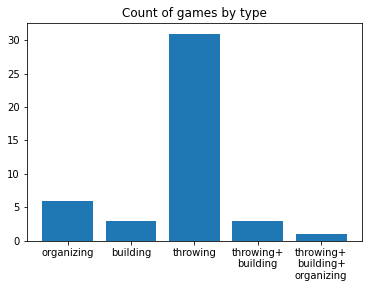

In [9]:
game_type_counts = stats_df.groupby(['is_throwing', 'is_building', 'is_organizing']).size().reset_index().rename(columns={0: 'num'})

labels = []
values = []
for index, row in game_type_counts.iterrows():
    elements = []
    if row.is_throwing: elements.append('throwing') 
    if row.is_building: elements.append('building') 
    if row.is_organizing: elements.append('organizing') 
    labels.append('+\n'.join(elements))
    values.append(row.num)

x_values = np.arange(len(values))
plt.bar(x_values, values)
plt.xticks(x_values, labels=labels)
plt.title('Count of games by type')


In [10]:
def _add_new_histogram_results(all_results, new_results, key):
    if isinstance(new_results, (list, tuple)):
        all_results[key].extend(new_results)
    else:
        all_results[key].append(new_results)


def _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values):
    results_by_key = defaultdict(list)

    for _, row in df.iterrows():
        group_by_key = row[group_by_col]
        row_values = row_value_func(row)

        # single key
        if isinstance(group_by_key, str):
            _add_new_histogram_results(results_by_key, row_values, group_by_key)
        
        # multiple keys
        else:
            if split_group_by_values:
                for key in group_by_key:
                    _add_new_histogram_results(results_by_key, row_values, key)

            else:
                group_by_key = '_'.join(sorted(group_by_key))
                _add_new_histogram_results(results_by_key, row_values, group_by_key)

    return results_by_key


def _add_new_bar_chart_results(all_results, new_results, key):    
    if isinstance(new_results, (list, tuple)):
        for new_res in new_results:
            _add_new_bar_chart_results(all_results, new_res, key)

    elif isinstance(new_results, dict):
        for result_key in new_results:
            all_results[key][result_key] += new_results[result_key]
    
    else:
        raise ValueError(f'_add_new_bar_chart_results expected dict (or list/tuple of dicts), received {type(new_results)}: {new_results}')


def _extract_bar_chart_data(df, group_by_col, row_value_func, split_group_by_values):
    results_by_key = defaultdict(lambda: defaultdict(lambda: 0))

    for _, row in df.iterrows():
        group_by_key = row[group_by_col]
        row_values = row_value_func(row)

        # single key
        if isinstance(group_by_key, str):
            _add_new_bar_chart_results(results_by_key, row_values, group_by_key)
        
        # multiple keys
        else:
            if split_group_by_values:
                for key in group_by_key:
                    _add_new_bar_chart_results(results_by_key, row_values, key)

            else:
                group_by_key = '_'.join(sorted(group_by_key))
                _add_new_bar_chart_results(results_by_key, row_values, group_by_key)

    return results_by_key


def parallel_histograms(df, group_by_col, row_value_func, split_group_by_values=False,
    figsize=(16, 6), plot_density=True, title='',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16):

    results_by_key = _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values)

    global_min = min([min(values) for values in results_by_key.values() if len(values) > 0])
    global_max = max([max(values) for values in results_by_key.values() if len(values) > 0])

    fig, axes = plt.subplots(1, len(results_by_key), figsize=figsize)

    for index, key in enumerate(results_by_key):
        ax = axes[index]
        ax.hist(results_by_key[key], range=(global_min, global_max), density=plot_density)
        ax.set_title(key, fontsize=ax_title_fontsize)

        if index == 0:
             ax.set_ylabel('Density' if plot_density else 'Count', fontsize=ax_label_fontsize)
        else:
            ax.set_yticks([])
    

    if title:
        plt.suptitle(title, fontsize=super_title_fontsize)
    
    plt.show()


def single_ax_histograms(df, group_by_col, row_value_func, split_group_by_values=False,
    figsize=(8, 6), plot_density=False, stacked=True, title='', cmap='Dark2', legend_loc='best', xlabel='',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16):

    results_by_key = _extract_histogram_data(df, group_by_col, row_value_func, split_group_by_values)
    keys = results_by_key.keys()
    values = [results_by_key[key] for key in keys]
    colormap = plt.cm.get_cmap(cmap)
    colors = [colormap(i) for i in range(len(keys))]

    plt.figure(figsize=figsize)
    plt.hist(values, label=list(keys), density=plot_density, stacked=stacked, color=colors)
    plt.legend(loc=legend_loc)
    plt.title(title, fontsize=super_title_fontsize)
    plt.ylabel('Density' if plot_density else 'Count', fontsize=ax_label_fontsize)
    plt.xlabel(xlabel, fontsize=ax_label_fontsize)    
    plt.show()


def single_ax_bar_chart(df, group_by_col, row_value_func, split_group_by_values=False,
    figsize=(8, 6), title='', cmap='Dark2', legend_loc='best', xlabel='', ylabel='Count',
    super_title_fontsize=24, ax_title_fontsize=16, ax_label_fontsize=16):

    results_by_key = _extract_bar_chart_data(df, group_by_col, row_value_func, split_group_by_values)
    outer_keys = results_by_key.keys()
    sorted_inner_keys =  sorted(set(
        [key for inner_keys in [list(x.keys()) for x in results_by_key.values()] 
        for key in inner_keys]
    ))
    current_start_values = np.zeros((len(sorted_inner_keys,)))

    colormap = plt.cm.get_cmap(cmap)
    colors = [colormap(i) for i in range(len(outer_keys))]

    plt.figure(figsize=figsize)

    for index, outer_key in enumerate(outer_keys):
        current_key_values = [results_by_key[outer_key][inner_key] for inner_key in sorted_inner_keys]
        # TODO: think about whether or not I want to support non-stacked
        plt.bar(sorted_inner_keys, current_key_values, bottom=current_start_values, 
            label=outer_key, color=colors[index])
        current_start_values += np.array(current_key_values)

    plt.legend(loc=legend_loc)
    plt.title(title, fontsize=super_title_fontsize)
    plt.ylabel(ylabel, fontsize=ax_label_fontsize)
    plt.xticks(rotation='vertical')
    plt.xlabel(xlabel, fontsize=ax_label_fontsize)    
    plt.show()


In [11]:
CoocurrenceDefinition = namedtuple(
    'CoocurrenceDefinition', 
    ('outer_key', 'inner_key', 'outer_primary_obj_only', 'inner_primary_obj_only'),
    defaults=(None, None, True, True)
)

SplitObjectPredicates = namedtuple(
    'SplitObjectPredicates', ('primary_objects', 'secondary_objects', 'predicates')
)

empty_coocurrence_dict = lambda: defaultdict(lambda: defaultdict(lambda: 0))

def update_coocurrence_dict(cooc_dict, outer_keys, inner_keys, omit_equals=False):
    for outer in outer_keys:
        for inner in inner_keys:
            if omit_equals and outer == inner:
                continue

            cooc_dict[outer][inner] += 1

def sort_by_count_desc(key_to_count):
    return [item[0] for item in sorted(key_to_count.items(), key=lambda item: item[1], reverse=True)]


def coocurrence_dict_to_matrix(cooc_dict):
    outer_key_counts = {key: sum(cooc_dict[key].values()) for key in cooc_dict}
    all_inner_keys = set([inner_key for keys in [inner_dict.keys() for inner_dict in cooc_dict.values()] for inner_key in keys])
    inner_key_counts = {inner_key: sum([cooc_dict[outer_key][inner_key] for outer_key in cooc_dict]) for inner_key in all_inner_keys}

    sorted_outer_keys = sort_by_count_desc(outer_key_counts)
    sorted_inner_keys = sort_by_count_desc(inner_key_counts)

    cooc_mat = np.zeros((len(sorted_outer_keys), len(sorted_inner_keys)))
    for i, outer in enumerate(sorted_outer_keys):
        for j, inner in enumerate(sorted_inner_keys):
            cooc_mat[i, j] = cooc_dict[outer][inner]

    return cooc_mat, sorted_outer_keys, sorted_inner_keys


def separate_objects_and_predicates(objects_with_predicates_list):
    primary_objects = []
    secondary_objects = []
    predicates = []

    if isinstance(objects_with_predicates_list, list):
        for object_with_predicates in objects_with_predicates_list:
            primary_objects.append(object_with_predicates['object'])

            if 'predicates' in object_with_predicates:
                for predicate_desc in object_with_predicates['predicates']:
                    if 'object' in predicate_desc:
                        secondary_objects.append(predicate_desc['object'])

                    if 'predicate' in predicate_desc:
                        predicates.append(predicate_desc['predicate'])

    return SplitObjectPredicates(primary_objects, secondary_objects, predicates)


def cooc_def_to_key(cooc_def):
    return f'{cooc_def.outer_key}_{cooc_def.inner_key}'


def extract_all_coocurrences(df, column_prefix, coocurrence_defs):
    relevant_columns = list(filter(lambda c: c.startswith(f'{column_prefix}_'), df.columns))
    obj_with_pred_columns = list(filter(
        lambda c: any([isinstance(x, list) and isinstance(x[0], dict) for x in df[c]]), 
        relevant_columns))

    coocurrence_dicts = {
        cooc_def_to_key(cooc_def): empty_coocurrence_dict()   
        for cooc_def in coocurrence_defs
    }

    for col in obj_with_pred_columns:
        coocurrence_dicts[f'{col}_object_predicate'] = empty_coocurrence_dict()
        coocurrence_dicts[f'{col}_object_object'] = empty_coocurrence_dict()

    for _, row in throwing_df.iterrows():
        row_values = {col: separate_objects_and_predicates(row[col]) if col in obj_with_pred_columns else row[col] for col in relevant_columns}

        # compute predefined coocurrences
        for cooc_def in coocurrence_defs:
            outer_col = f'{column_prefix}_{cooc_def.outer_key}'
            inner_col = f'{column_prefix}_{cooc_def.inner_key}'

            outer_values = row_values[outer_col]
            inner_values = row_values[inner_col]

            if outer_col in obj_with_pred_columns:
                if cooc_def.outer_primary_obj_only:
                    outer_values = outer_values.primary_objects[:]
                else:
                    outer_values = outer_values.primary_objects + outer_values.secondary_objects

            if inner_col in obj_with_pred_columns:
                if cooc_def.inner_primary_obj_only:
                    inner_values = inner_values.primary_objects[:]
                else:
                    inner_values = inner_values.primary_objects + inner_values.secondary_objects

            update_coocurrence_dict(coocurrence_dicts[cooc_def_to_key(cooc_def)], outer_values, inner_values)

        # comute generic object-object and object-predicate coocurrences
        for col in obj_with_pred_columns:
            if isinstance(row[col], list):
                for object_with_predicates in row[col]:
                    first_object = object_with_predicates['object']
                    if 'predicates' in object_with_predicates:
                        for predicate_desc in object_with_predicates['predicates']:
                            second_object = None
                            if 'object' in predicate_desc:
                                second_object = predicate_desc['object']
                                coocurrence_dicts[f'{col}_object_object'][first_object][second_object] += 1
                                coocurrence_dicts[f'{col}_object_object'][second_object][first_object] += 1

                            if 'predicate' in predicate_desc:
                                predicate = predicate_desc['predicate']
                                
                                coocurrence_dicts[f'{col}_object_predicate'][first_object][predicate] += 1
                                if second_object:
                                    coocurrence_dicts[f'{col}_object_predicate'][second_object][predicate] += 1

    # combine the individual object-predicate coocurrences to the combined ones
    coocurrence_dicts['all_object_predicate'] = empty_coocurrence_dict()
    coocurrence_dicts['all_object_object'] = empty_coocurrence_dict()

    for col in obj_with_pred_columns:
        for template in '{key}_object_predicate', '{key}_object_object':
            overall_cooc_dict = coocurrence_dicts[template.format(key='all')]
            current_cooc_dict = coocurrence_dicts[template.format(key=col)]

            for outer_key in current_cooc_dict:
                for inner_key in current_cooc_dict[outer_key]:
                    overall_cooc_dict[outer_key][inner_key] += current_cooc_dict[outer_key][inner_key]

    return coocurrence_dicts


def plot_coocurrence_data(cooc_dict, title='', xlabel='', ylabel='', figsize=(12, 12),
    title_fontsize=24, ax_label_fontsize=20, tick_fontsize=16, cmap=None): 
    cooc_mat, outer_keys, inner_keys = coocurrence_dict_to_matrix(cooc_dict)

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    plt.imshow(cooc_mat, cmap=cmap)

    plt.xticks(np.arange(len(inner_keys)), inner_keys, rotation='vertical', fontsize=tick_fontsize)
    ax.xaxis.set_ticks_position('top')
    # ax.xaxis.set_label_position('top')
    plt.yticks(np.arange(len(outer_keys)), outer_keys, fontsize=tick_fontsize)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=tick_fontsize)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=ax_label_fontsize)
    plt.ylabel(ylabel, fontsize=ax_label_fontsize)
    plt.show()




# Between-game-type visualizations


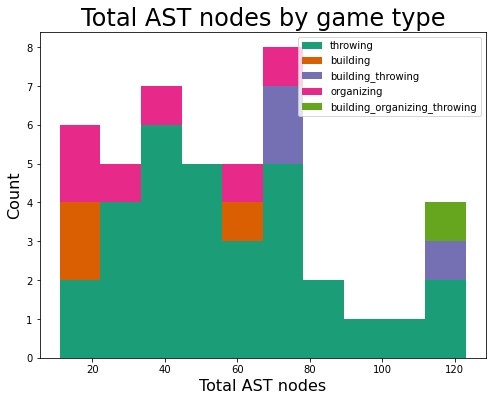

In [12]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.ast_nodes, 
    title='Total AST nodes by game type', xlabel='Total AST nodes', legend_loc='upper right')

/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


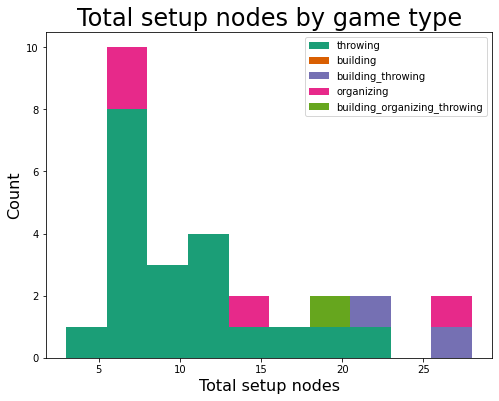

In [13]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.setup_nodes, 
    title='Total setup nodes by game type', xlabel='Total setup nodes', legend_loc='upper right')

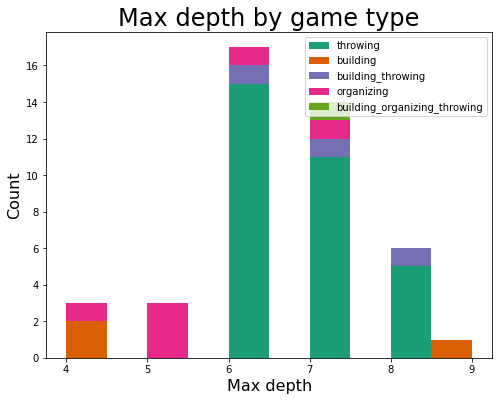

In [14]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.max_depth, 
    title='Max depth by game type', xlabel='Max depth', legend_loc='upper right')

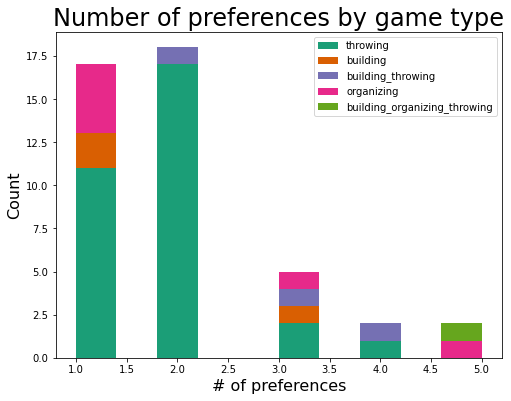

In [15]:
single_ax_histograms(stats_df, 'game_type', lambda row: row.num_preferences, 
    title='Number of preferences by game type', xlabel='# of preferences', legend_loc='upper right')

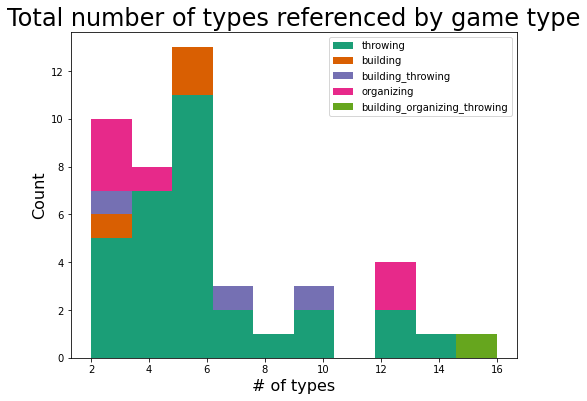

In [16]:
def extract_num_types_referenced(row):
    if isinstance(row.object_types_referenced, dict):
        return len(row.object_types_referenced)

    return 0


single_ax_histograms(stats_df, 'game_type', extract_num_types_referenced, 
    title='Total number of types referenced by game type', xlabel='# of types', legend_loc='upper right')

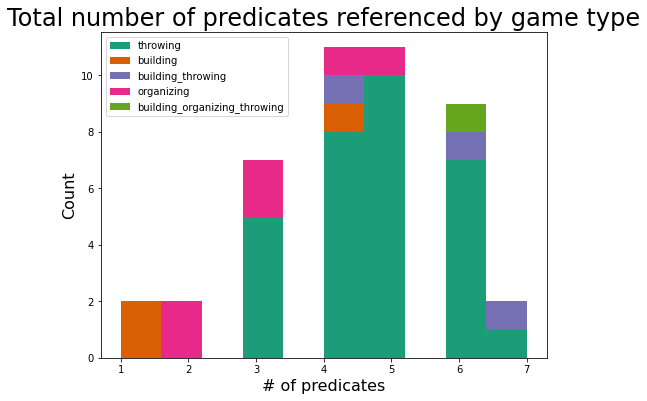

In [17]:
def extract_predicates_referenced(row):
    if isinstance(row.predicates_referenced, dict):
        return len(row.predicates_referenced)

    return 0


single_ax_histograms(stats_df, 'game_type', extract_predicates_referenced, 
    title='Total number of predicates referenced by game type', xlabel='# of predicates', 
    legend_loc='upper left')

In the next two plots, and the two plots that follow, I plot references to types (in the first two) and predicates (in the second two) by game type. The first of each two plots counts individual references to each type (so if a game refers to a type three times, it adds 3), while the second of each two plots counts how many games refer to each type (so hthe same game referring to a type three times will only add 1).

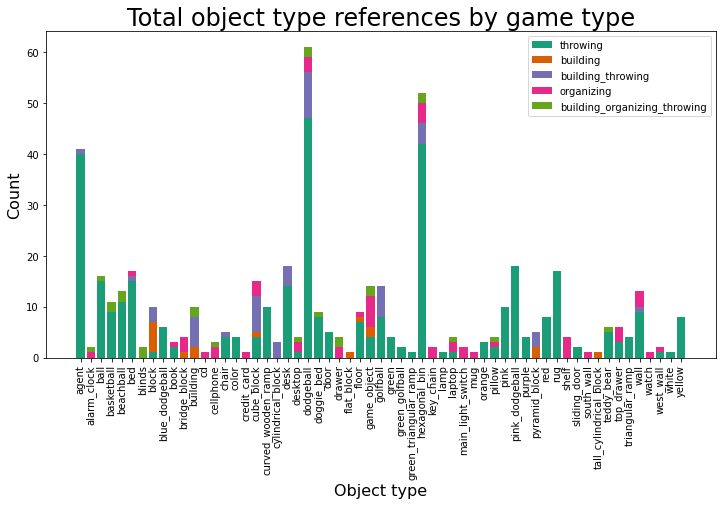

In [18]:
single_ax_bar_chart(stats_df, 'game_type', lambda row: row.object_types_referenced,
    title='Total object type references by game type', xlabel='Object type', figsize=(12, 6))


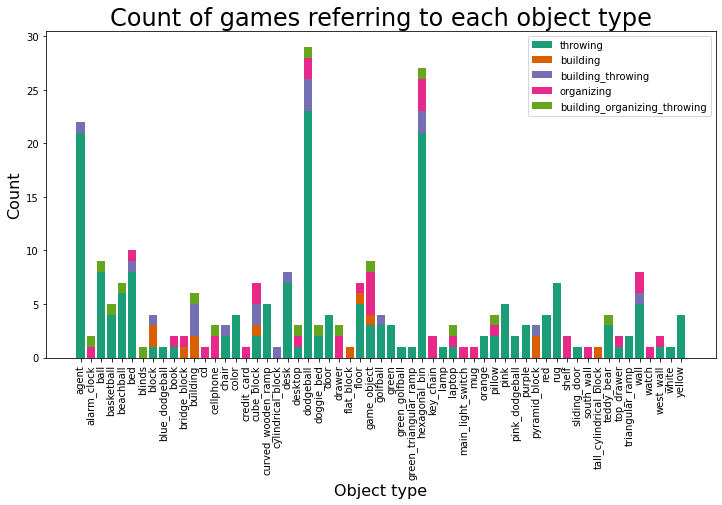

In [19]:
def dict_keys_to_1(row):
    if isinstance(row.object_types_referenced, dict):
        return {key: 1 for key in row.object_types_referenced}

single_ax_bar_chart(stats_df, 'game_type', dict_keys_to_1,
    title='Count of games referring to each object type', xlabel='Object type', figsize=(12, 6))


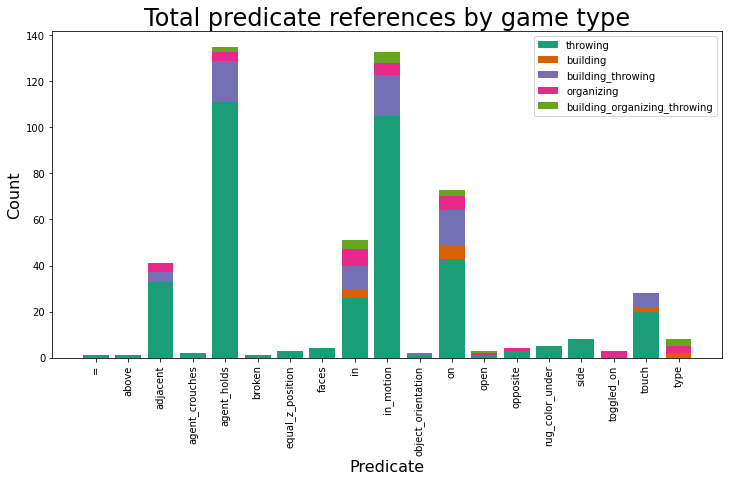

In [20]:
single_ax_bar_chart(stats_df, 'game_type', lambda row: row.predicates_referenced,
    title='Total predicate references by game type', xlabel='Predicate', figsize=(12, 6))


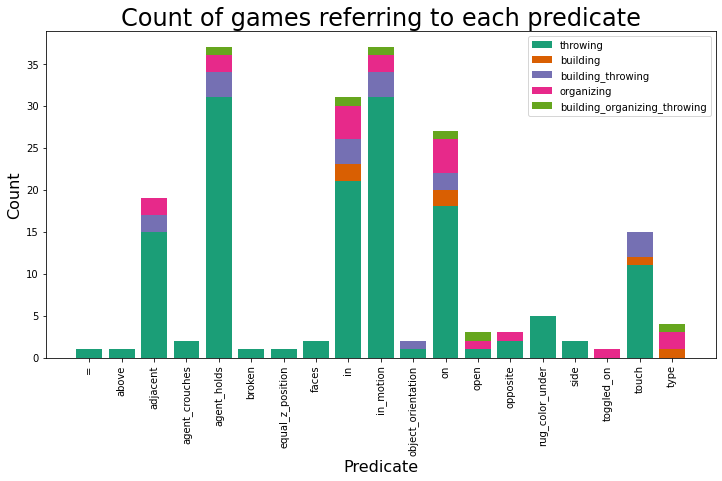

In [21]:
def dict_keys_to_1(row):
    if isinstance(row.predicates_referenced, dict):
        return {key: 1 for key in row.predicates_referenced}

single_ax_bar_chart(stats_df, 'game_type', dict_keys_to_1,
    title='Count of games referring to each predicate', xlabel='Predicate', figsize=(12, 6))


# Throwing game visualizations

* The fiirst set of plots visualize coocurrence matrices between different game elmenets. For example:
    * Thrown object <> thrown game goal (to get something in, on, to hit another object, etc.)
    * Thrown object <> target object coocurrence
    * Coocurrences between various types of objects in the thrown game schema (the object thrown to, the object thrown from, objects and predicates, etc.)
* **In all of these, I don't currently control for the fact that same objects appear in more of the rooms -- I could count how many games I have in each room, note which objects appear in each room, and account for that in my analysis, right?**
* I can also generate analyses for throwing games like the analyses I generated for all games above. I'll generate a few of those plots, to give some examples, below the cocourrence matrices. Some of the things I could plot include:
    * Number of preferences?
    * Average length/depth of preferences?
    * Max depth?
    * Total type references
    * Number of types referenced
    * **Would complexity of the setup be an interesting thing to quantify?**

In [22]:
throwing_df = stats_df[stats_df.is_throwing == 1]

throwing_df.head()

,src,src_file,game_name,domain_name,room,room_name,num_preferences,length_of_then,average_length_of_then,setup_objects_quantified,...,throwing_goal,throwing_to,throwing_from,throwing_on,building_objects,building_goal,building_structure,building_order,organizing,organizing_objects
0,3,interactive-beta,6172feb1665491d1efbce164,medium-objects-room-v1,1,Medium,2,"[3, 2]",2.5,[2],...,[hit],[{'object': 'hexagonal_bin'}],NaN,"[{'object': 'large_triangular_ramp', 'predicat...",NaN,NaN,NaN,NaN,NaN,NaN
1,3,interactive-beta,5f77754ba932fb2c4ba181d8,many-objects-room-v1,2,Many,2,"[3, 3]",3,[],...,[in],"[{'object': 'top_drawer', 'predicates': [{'pre...","[{'object': 'door', 'predicates': [{'predicate...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,interactive-beta,5bc79f652885710001a0e82a,few-objects-room-v1,0,Few,1,[3],3,[],...,[in],[{'object': 'hexagonal_bin'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,interactive-beta,614dec67f6eb129c3a77defd,medium-objects-room-v1,1,Medium,2,"[3, 3]",3,"[1, 1]",...,[in],"[{'object': 'hexagonal_bin', 'predicates': [{'...","[{'object': 'desk', 'predicates': [{'predicate...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,interactive-beta,615b40bb6cdb0f1f6f291f45,few-objects-room-v1,0,Few,2,"[3, 3]",3,[1],...,[over],[{'object': 'curved_wooden_ramp'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
THROWING_COOCURRENCE_DEFINITIONS = (
    CoocurrenceDefinition('objects', 'goal'),
    CoocurrenceDefinition('objects', 'to'),
    CoocurrenceDefinition('objects', 'on'),
    CoocurrenceDefinition('goal', 'to'),
    CoocurrenceDefinition('on', 'to'),
    CoocurrenceDefinition('from', 'to', False, False),
)

throwing_coocurrences = extract_all_coocurrences(stats_df, 'throwing', THROWING_COOCURRENCE_DEFINITIONS)

throwing_coocurrences.keys()

dict_keys(['objects_goal', 'objects_to', 'objects_on', 'goal_to', 'on_to', 'from_to', 'throwing_to_object_predicate', 'throwing_to_object_object', 'throwing_from_object_predicate', 'throwing_from_object_object', 'throwing_on_object_predicate', 'throwing_on_object_object', 'all_object_predicate', 'all_object_object'])

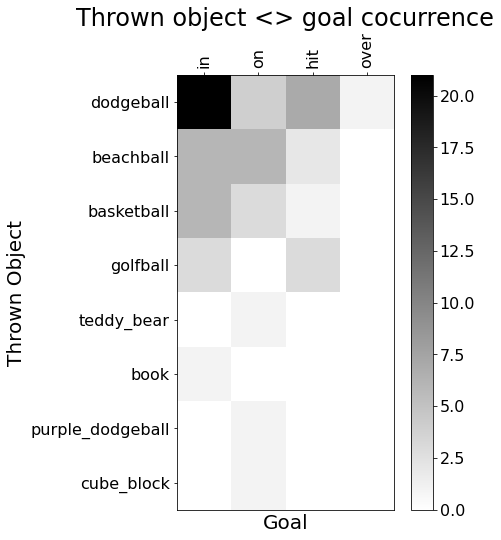

In [24]:
plot_coocurrence_data(throwing_coocurrences['objects_goal'], 
    'Thrown object <> goal cocurrence', 'Goal', 'Thrown Object', (6, 8), cmap='gist_yarg')

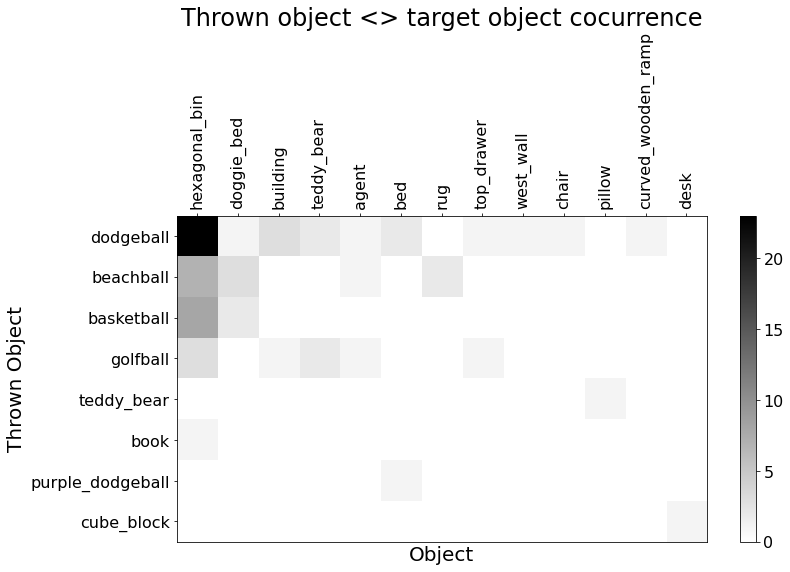

In [25]:
plot_coocurrence_data(throwing_coocurrences['objects_to'], 
    'Thrown object <> target object cocurrence', 'Object', 'Thrown Object', (12, 6), cmap='gist_yarg')

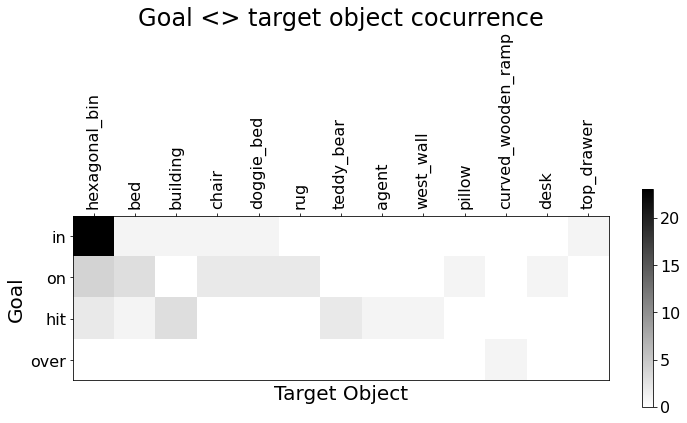

In [26]:
plot_coocurrence_data(throwing_coocurrences['goal_to'], 
    'Goal <> target object cocurrence', 'Target Object', 'Goal', (12, 4), cmap='gist_yarg')

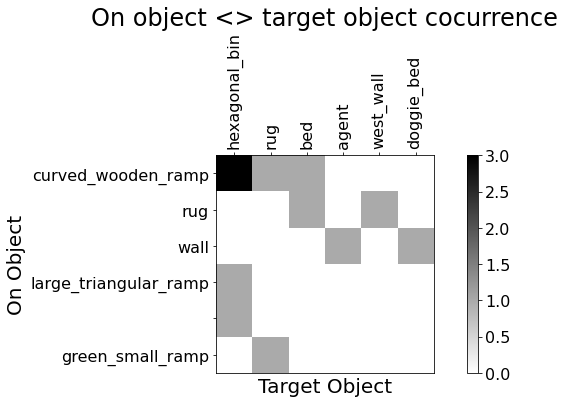

In [27]:
plot_coocurrence_data(throwing_coocurrences['on_to'], 
    'On object <> target object cocurrence', 'Target Object', 'On Object', (12, 4), cmap='gist_yarg')

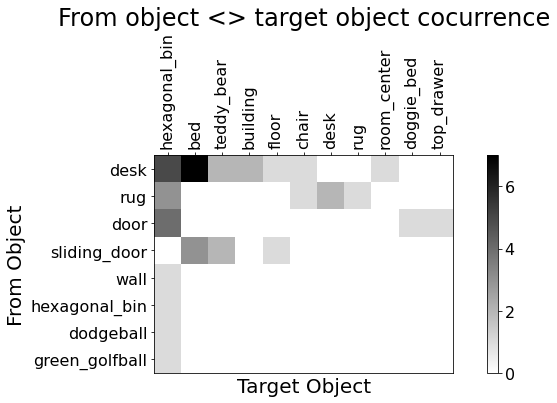

In [28]:
plot_coocurrence_data(throwing_coocurrences['from_to'], 
    'From object <> target object cocurrence', 'Target Object', 'From Object', (12, 4), cmap='gist_yarg')

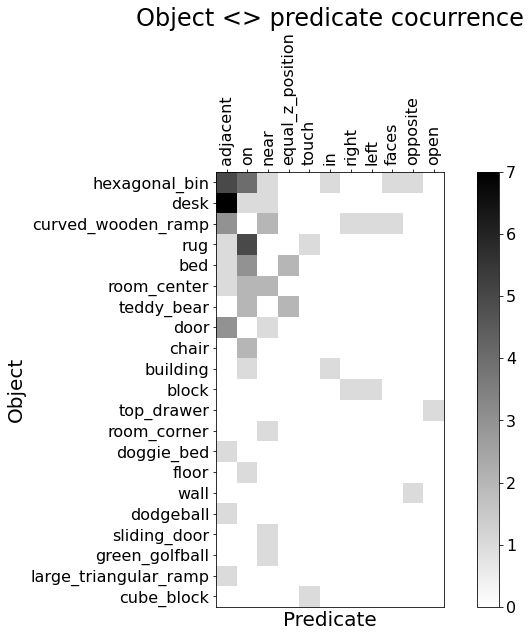

In [29]:
plot_coocurrence_data(throwing_coocurrences['all_object_predicate'], 
    'Object <> predicate cocurrence', 'Predicate', 'Object', (12, 8), cmap='gist_yarg')

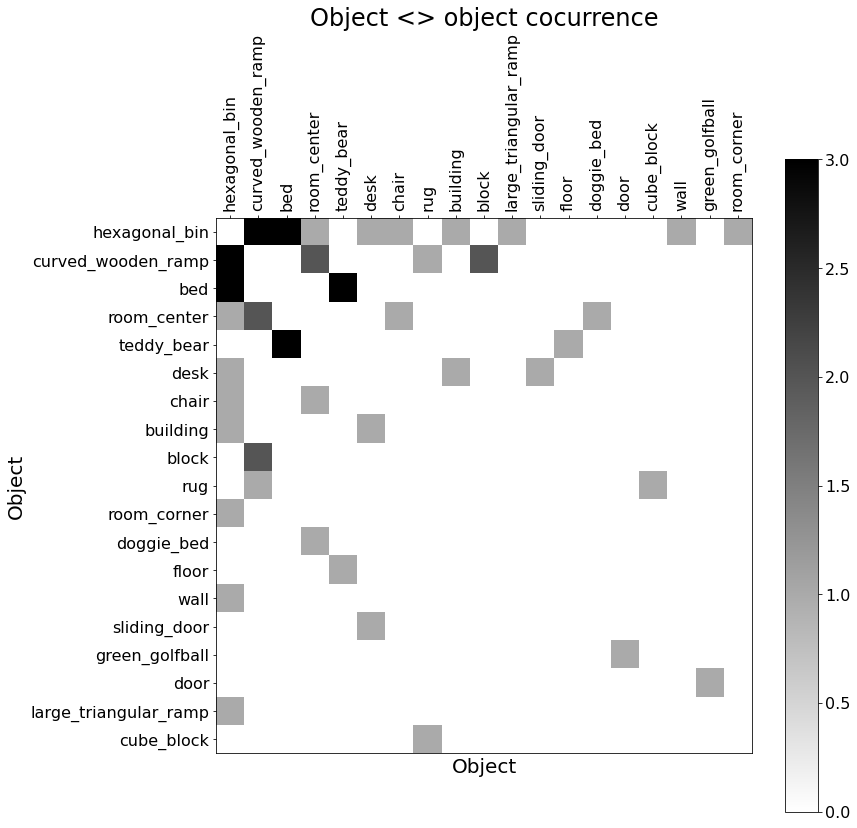

In [30]:
plot_coocurrence_data(throwing_coocurrences['all_object_object'], 
    'Object <> object cocurrence', 'Object', 'Object', (12, 12), cmap='gist_yarg')

## Throwing game bar charts

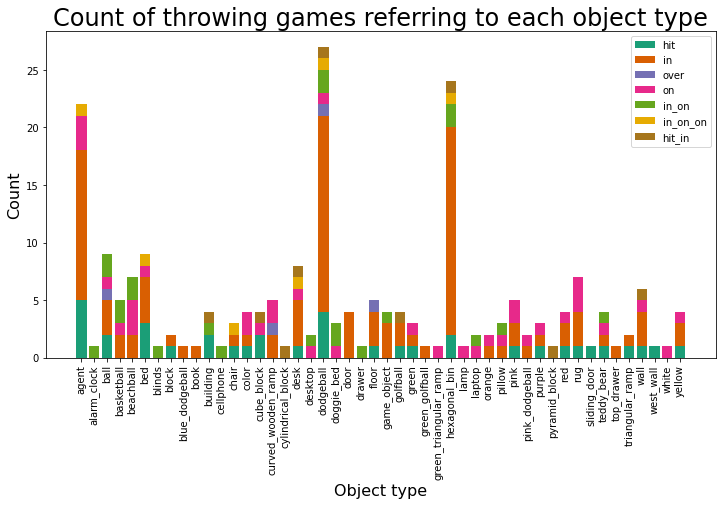

In [31]:
def dict_keys_to_1(row):
    if isinstance(row.object_types_referenced, dict):
        return {key: 1 for key in row.object_types_referenced}

single_ax_bar_chart(throwing_df, 'throwing_goal', dict_keys_to_1,
    title='Count of throwing games referring to each object type', xlabel='Object type', figsize=(12, 6))



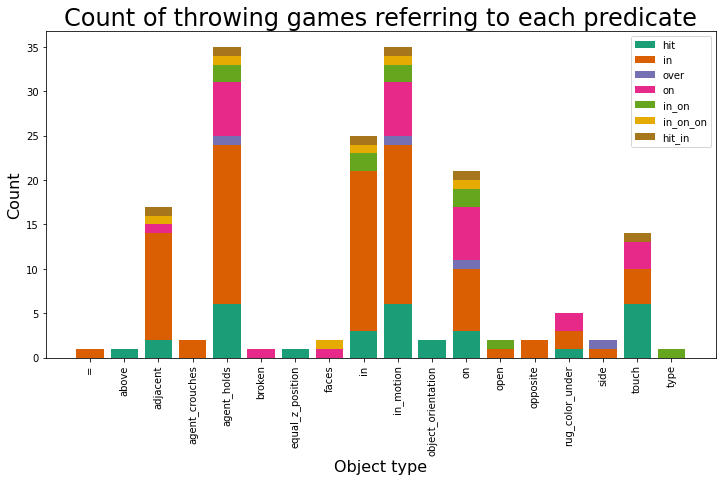

In [32]:
def dict_keys_to_1(row):
    if isinstance(row.predicates_referenced, dict):
        return {key: 1 for key in row.predicates_referenced}

single_ax_bar_chart(throwing_df, 'throwing_goal', dict_keys_to_1,
    title='Count of throwing games referring to each predicate', xlabel='Object type', figsize=(12, 6))



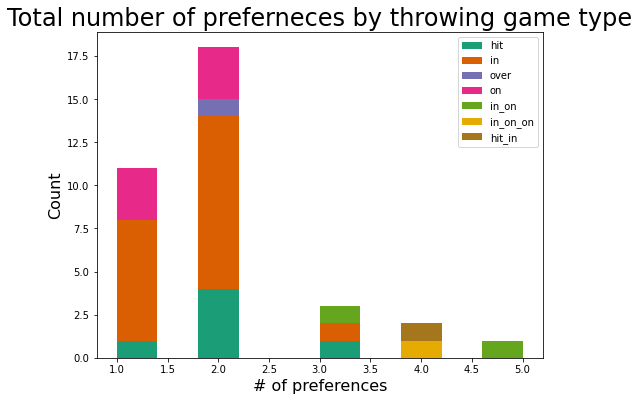

In [33]:
single_ax_histograms(throwing_df, 'throwing_goal', lambda row: row.num_preferences, 
    title='Total number of preferneces by throwing game type', xlabel='# of preferences', legend_loc='upper right')

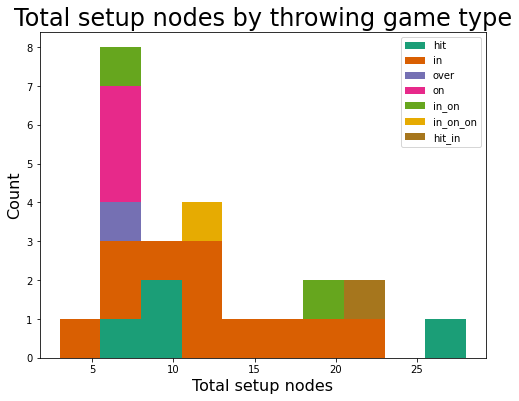

In [34]:
single_ax_histograms(throwing_df, 'throwing_goal', lambda row: row.setup_nodes, 
    title='Total setup nodes by throwing game type', xlabel='Total setup nodes', legend_loc='upper right')

In [35]:
building_df_or_organizing_df = stats_df[np.logical_or(stats_df.is_building == 1, stats_df.is_organizing == 1)]
building_df = stats_df[stats_df.is_building == 1]
organizing_df = stats_df[stats_df.is_organizing == 1]
non_throwing_df = stats_df[stats_df.is_throwing == 0]

len(building_df_or_organizing_df), len(building_df), len(organizing_df), len(non_throwing_df)

(13, 7, 7, 9)

## Non-throwing game statistics

See the above cell -- we have a total of 9 games that don't involve any throwing, or alternatively, a total of 13 games that involve either building or organizing. 

**Is this enough to separately extract statistics over? Or too little? If yes, anything specific we want to see?**